[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/jkitchin/s26-06642/blob/main/dsmles/09-nonlinear-methods/nonlinear-methods.ipynb)

In [ ]:
! pip install -q pycse
from pycse.colab import pdf

# Module 09: Nonlinear Methods

Modeling complex, nonlinear relationships.

## Learning Objectives

1. Recognize when linear models are insufficient
2. Apply polynomial features for nonlinear relationships
3. Use Support Vector Machines (SVMs) for regression
4. Understand kernel methods
5. Choose appropriate nonlinear models

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score

```{index} nonlinear regression
```


## When Linear Models Fail: Recognizing Nonlinearity

Linear models assume the relationship between features and target is a straight line (or hyperplane). But many real-world relationships are nonlinear:

### Chemical Engineering Examples

| System | Relationship | Why It's Nonlinear |
|--------|--------------|-------------------|
| Enzyme kinetics | Michaelis-Menten | Saturation at high [S] |
| Reaction rates | Arrhenius | Exponential temperature dependence |
| Adsorption | Langmuir isotherm | Saturation of surface sites |
| Heat transfer | Radiation | T⁴ dependence |
| Mixing | Log-mean differences | Logarithmic average |

### How to Detect Nonlinearity

1. **Plot residuals**: If they show a curve, the relationship is nonlinear
2. **Domain knowledge**: You know the physics suggests a specific form
3. **Low R² despite good features**: Linear model can't capture the pattern
4. **Scatter plot inspection**: Relationship visibly curves

### Two Approaches to Nonlinearity

1. **Transform the data**: Log, square root, inverse (if you know the form)
2. **Use nonlinear models**: Polynomial features, SVR, trees (if form is unknown)

In [2]:
# Load enzyme kinetics dataset
import pandas as pd
url = "https://raw.githubusercontent.com/jkitchin/s26-06642/main/dsmles/data/enzyme_kinetics.csv"
df_enzyme = pd.read_csv(url)

S = df_enzyme['substrate'].values
V = df_enzyme['rate'].values

print(f"Loaded {len(S)} data points")

Loaded 100 data points


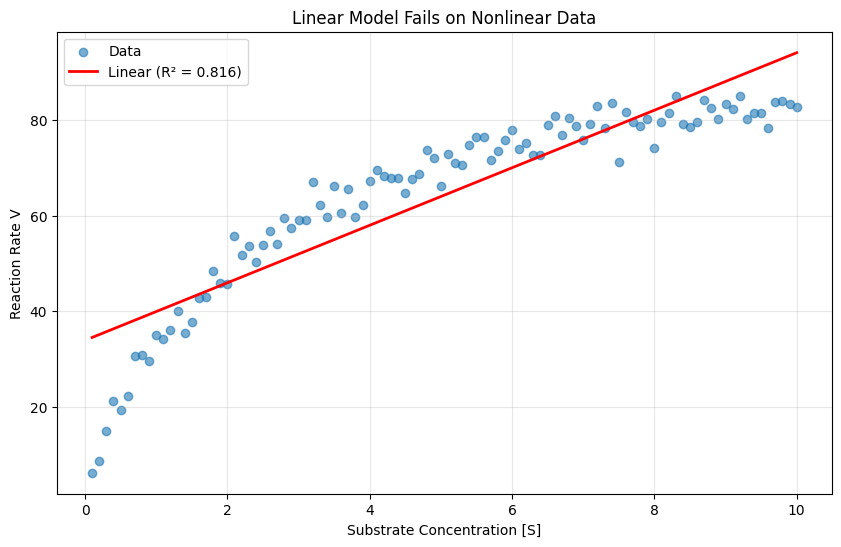

In [3]:
# Try linear regression
X = S.reshape(-1, 1)
y = V

linear = LinearRegression()
linear.fit(X, y)

plt.figure(figsize=(10, 6))
plt.scatter(S, V, alpha=0.6, label='Data')
plt.plot(S, linear.predict(X), 'r-', linewidth=2, label=f'Linear (R² = {linear.score(X, y):.3f})')
plt.xlabel('Substrate Concentration [S]')
plt.ylabel('Reaction Rate V')
plt.title('Linear Model Fails on Nonlinear Data')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

```{index} polynomial features
```


## Polynomial Features: The Simple Extension

The easiest way to capture nonlinearity is to add polynomial terms. Transform:

$$x \rightarrow [x, x^2, x^3, \ldots, x^d]$$

Then apply linear regression on these expanded features. The model is still *linear in parameters* (just fitting coefficients), but *nonlinear in the input*.

### The Tradeoff

| Degree | Flexibility | Risk |
|--------|-------------|------|
| 1 | Linear only | Underfitting |
| 2 | Captures curvature | Usually safe |
| 3-4 | More complex shapes | Often good balance |
| 5+ | Very flexible | High overfitting risk |

### The Explosion of Features

With d features and polynomial degree p, you get:
$$\binom{d+p}{p}$$ features

For d=10 features, degree=3: **286 features!**

This is why polynomial features are best for:
- Few original features (1-5)
- Moderate degrees (2-4)
- Combined with regularization

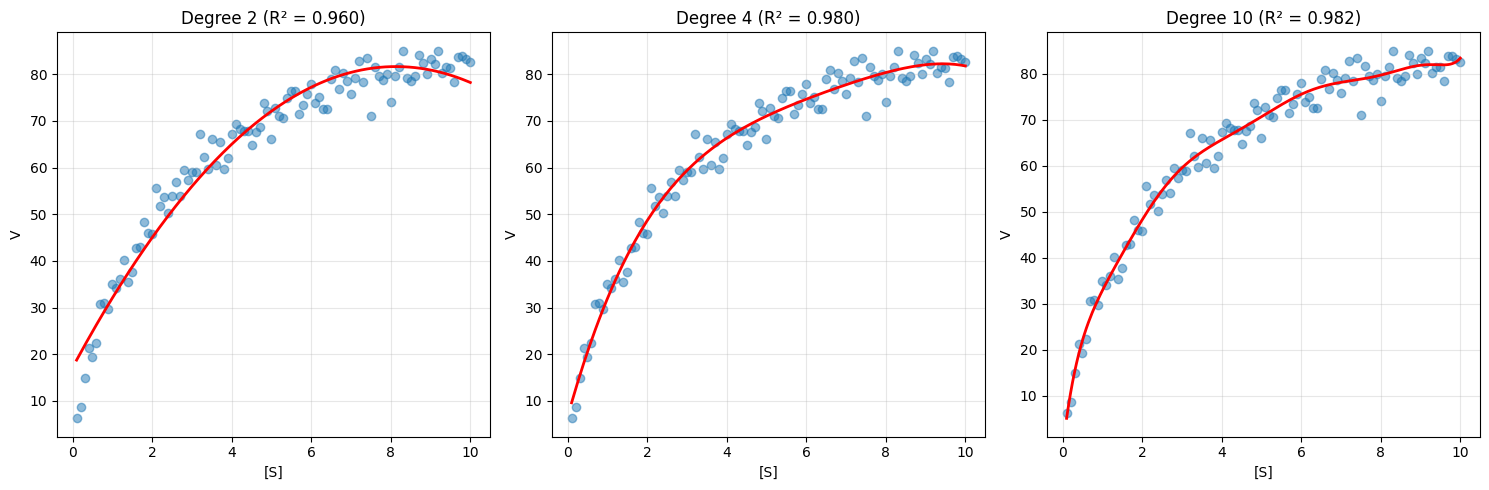

In [4]:
# Polynomial regression with different degrees
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for ax, degree in zip(axes, [2, 4, 10]):
    # Create polynomial features
    poly = PolynomialFeatures(degree=degree, include_bias=False)
    X_poly = poly.fit_transform(X)
    
    # Fit model
    model = LinearRegression()
    model.fit(X_poly, y)
    
    # Plot
    ax.scatter(S, V, alpha=0.5, label='Data')
    S_smooth = np.linspace(0.1, 10, 200).reshape(-1, 1)
    X_smooth_poly = poly.transform(S_smooth)
    ax.plot(S_smooth, model.predict(X_smooth_poly), 'r-', linewidth=2)
    ax.set_xlabel('[S]')
    ax.set_ylabel('V')
    ax.set_title(f'Degree {degree} (R² = {model.score(X_poly, y):.3f})')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

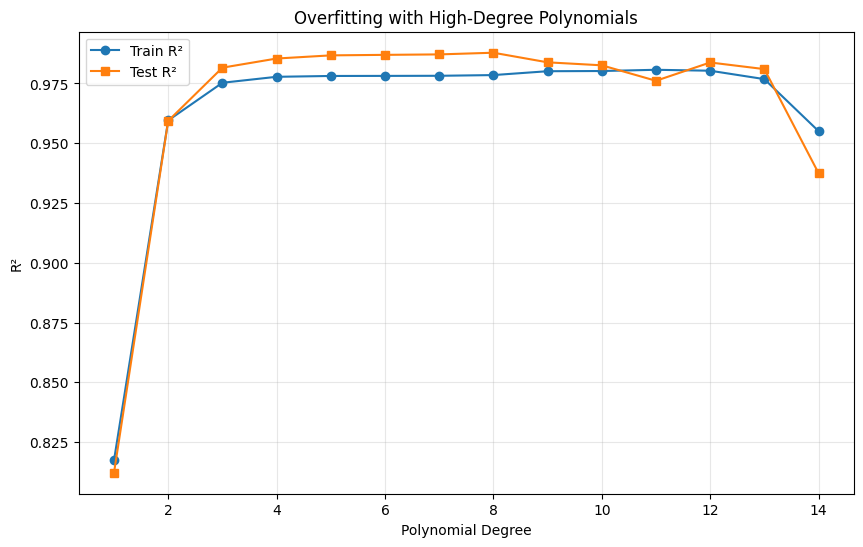

In [5]:
# Check for overfitting with train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

results = []
for degree in range(1, 15):
    poly = PolynomialFeatures(degree=degree, include_bias=False)
    
    X_train_poly = poly.fit_transform(X_train)
    X_test_poly = poly.transform(X_test)
    
    model = LinearRegression()
    model.fit(X_train_poly, y_train)
    
    results.append({
        'Degree': degree,
        'Train R²': model.score(X_train_poly, y_train),
        'Test R²': model.score(X_test_poly, y_test)
    })

results_df = pd.DataFrame(results)

plt.figure(figsize=(10, 6))
plt.plot(results_df['Degree'], results_df['Train R²'], 'o-', label='Train R²')
plt.plot(results_df['Degree'], results_df['Test R²'], 's-', label='Test R²')
plt.xlabel('Polynomial Degree')
plt.ylabel('R²')
plt.title('Overfitting with High-Degree Polynomials')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

/Users/jkitchin/Dropbox/emacs/projects/s26-06642/.venv/lib/python3.12/site-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=1.71846e-18): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/Users/jkitchin/Dropbox/emacs/projects/s26-06642/.venv/lib/python3.12/site-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=1.52706e-18): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/Users/jkitchin/Dropbox/emacs/projects/s26-06642/.venv/lib/python3.12/site-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=1.51624e-18): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/Users/jkitchin/Dropbox/emacs/projects/s26-06642/.venv/lib/python3.12/site-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=1.44943e-18): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
/Users/jkitchin/Dropbox/emacs/projects/s

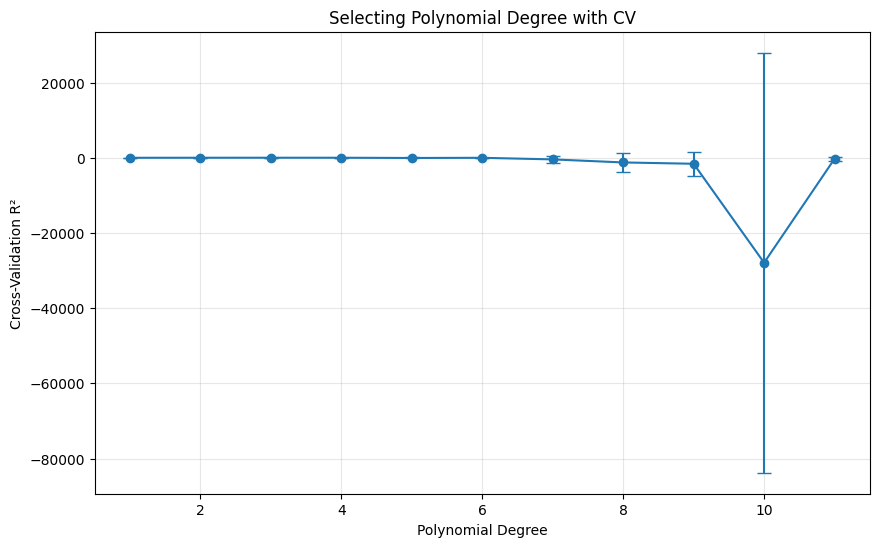

Best polynomial degree: 3


In [6]:
# Use cross-validation to select best degree
cv_scores = []

for degree in range(1, 12):
    pipeline = Pipeline([
        ('poly', PolynomialFeatures(degree=degree, include_bias=False)),
        ('model', Ridge(alpha=0.1))  # Add regularization
    ])
    
    scores = cross_val_score(pipeline, X, y, cv=5, scoring='r2')
    cv_scores.append({
        'Degree': degree,
        'Mean CV R²': scores.mean(),
        'Std': scores.std()
    })

cv_df = pd.DataFrame(cv_scores)

plt.figure(figsize=(10, 6))
plt.errorbar(cv_df['Degree'], cv_df['Mean CV R²'], 
             yerr=cv_df['Std'], fmt='o-', capsize=5)
plt.xlabel('Polynomial Degree')
plt.ylabel('Cross-Validation R²')
plt.title('Selecting Polynomial Degree with CV')
plt.grid(True, alpha=0.3)
plt.show()

best_degree = cv_df.loc[cv_df['Mean CV R²'].idxmax(), 'Degree']
print(f"Best polynomial degree: {best_degree}")

```{index} Support Vector Regression, SVR, kernel methods, epsilon tube
```


## Support Vector Regression (SVR): The Kernel Trick

SVR takes a completely different approach to nonlinearity. Instead of explicitly creating polynomial features, it uses the **kernel trick** to implicitly work in a high-dimensional space.

### The Key Idea

1. Map data to a high-dimensional space where it becomes linearly separable
2. Fit a linear model in that space
3. The kernel function computes dot products in the high-dimensional space without ever explicitly computing the mapping

### The ε-Tube

Unlike OLS (which penalizes all errors), SVR fits a "tube" of width ε around the data:
- Points inside the tube: no penalty
- Points outside the tube: penalized by distance to the tube

This makes SVR robust to small noise—it only cares about points that deviate significantly.

### Why SVR Works Well

- Handles nonlinearity without explicit feature engineering
- Robust to outliers (ε-tube ignores small noise)
- Works well in high dimensions
- Doesn't require specifying the functional form

### The Cost

- Less interpretable (no meaningful coefficients)
- Requires feature scaling
- Hyperparameters can be tricky to tune
- Slower than linear models for large datasets

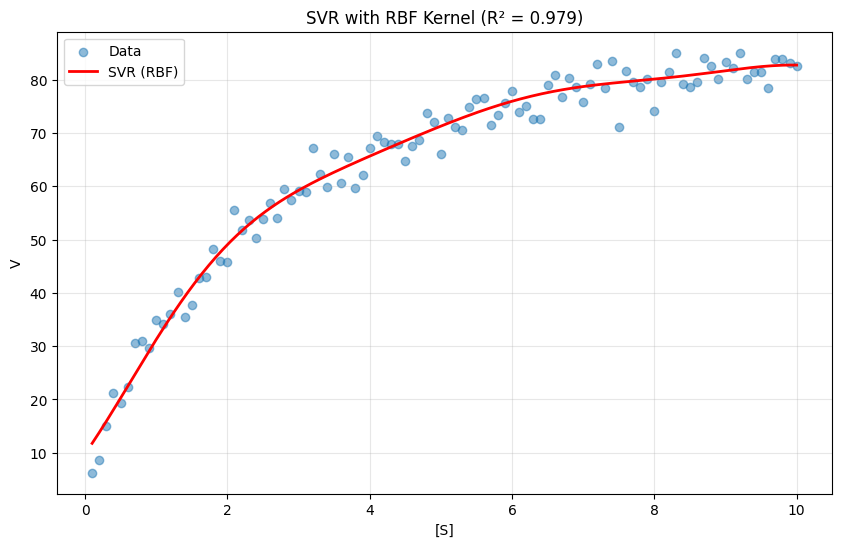

In [7]:
# SVR with RBF kernel
# Important: Scale features for SVR!
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

svr = SVR(kernel='rbf', C=100, epsilon=0.1)
svr.fit(X_scaled, y)

plt.figure(figsize=(10, 6))
plt.scatter(S, V, alpha=0.5, label='Data')
S_smooth = np.linspace(0.1, 10, 200).reshape(-1, 1)
X_smooth_scaled = scaler.transform(S_smooth)
plt.plot(S_smooth, svr.predict(X_smooth_scaled), 'r-', linewidth=2, label='SVR (RBF)')
plt.xlabel('[S]')
plt.ylabel('V')
plt.title(f'SVR with RBF Kernel (R² = {svr.score(X_scaled, y):.3f})')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

```{index} RBF kernel
```


## SVR Kernels

Different kernels for different relationships:

| Kernel | Formula | Use Case |
|--------|---------|----------|
| Linear | $x \cdot x'$ | Linear relationships |
| RBF | $\exp(-\gamma \|x-x'\|^2)$ | General nonlinear (most common) |
| Polynomial | $(\gamma x \cdot x' + r)^d$ | Polynomial-like relationships |

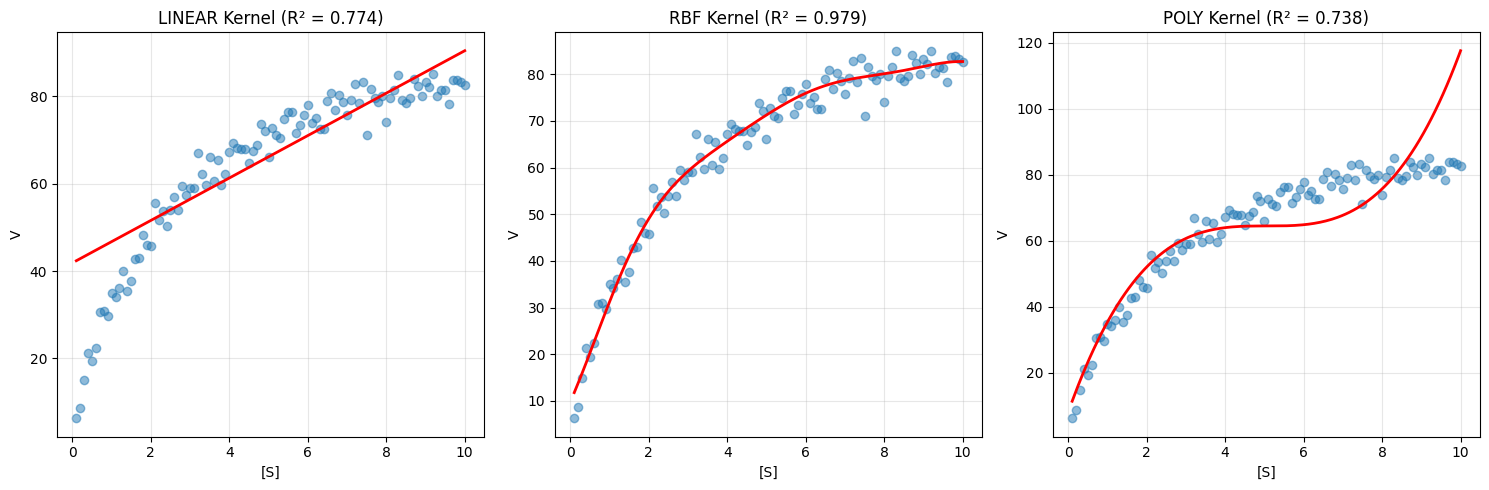

In [8]:
# Compare different kernels
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

kernels = ['linear', 'rbf', 'poly']
kernel_params = [
    {'kernel': 'linear', 'C': 100},
    {'kernel': 'rbf', 'C': 100, 'gamma': 'scale'},
    {'kernel': 'poly', 'C': 100, 'degree': 3}
]

for ax, name, params in zip(axes, kernels, kernel_params):
    svr = SVR(**params)
    svr.fit(X_scaled, y)
    
    ax.scatter(S, V, alpha=0.5, label='Data')
    ax.plot(S_smooth, svr.predict(X_smooth_scaled), 'r-', linewidth=2)
    ax.set_xlabel('[S]')
    ax.set_ylabel('V')
    ax.set_title(f'{name.upper()} Kernel (R² = {svr.score(X_scaled, y):.3f})')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

```{index} gamma parameter
```


## SVR Hyperparameters

- **C**: Regularization (higher = less regularization, tighter fit)
- **epsilon**: Width of the tube (points inside aren't penalized)
- **gamma** (RBF): Controls kernel width (higher = more local)

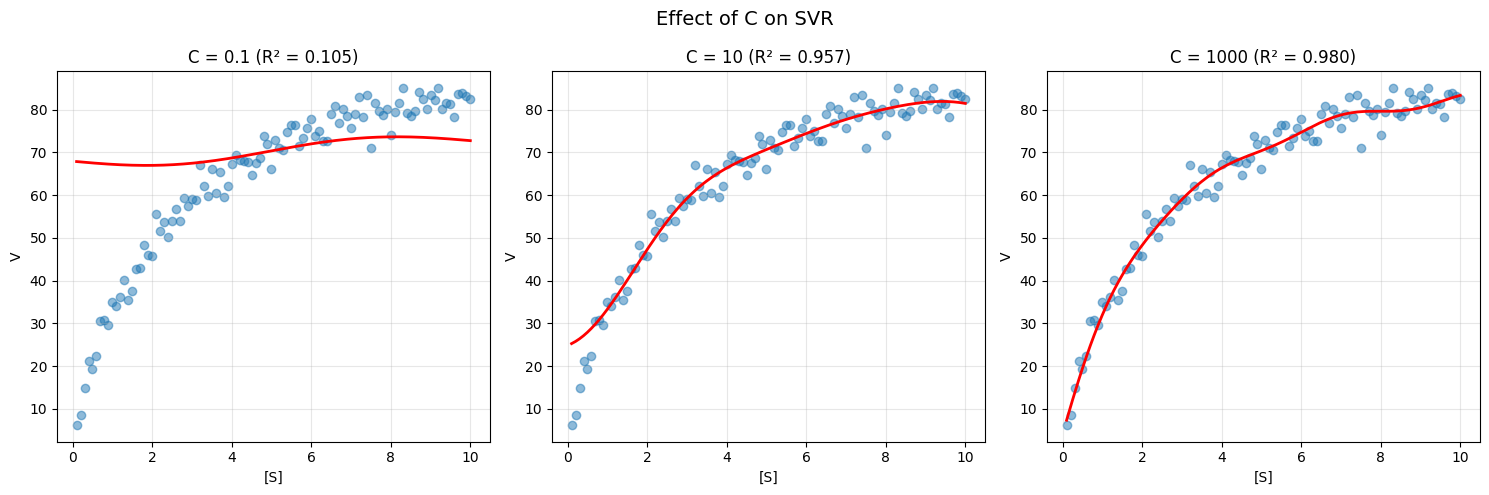

In [9]:
# Effect of C
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for ax, C in zip(axes, [0.1, 10, 1000]):
    svr = SVR(kernel='rbf', C=C)
    svr.fit(X_scaled, y)
    
    ax.scatter(S, V, alpha=0.5)
    ax.plot(S_smooth, svr.predict(X_smooth_scaled), 'r-', linewidth=2)
    ax.set_xlabel('[S]')
    ax.set_ylabel('V')
    ax.set_title(f'C = {C} (R² = {svr.score(X_scaled, y):.3f})')
    ax.grid(True, alpha=0.3)

plt.suptitle('Effect of C on SVR', fontsize=14)
plt.tight_layout()
plt.show()

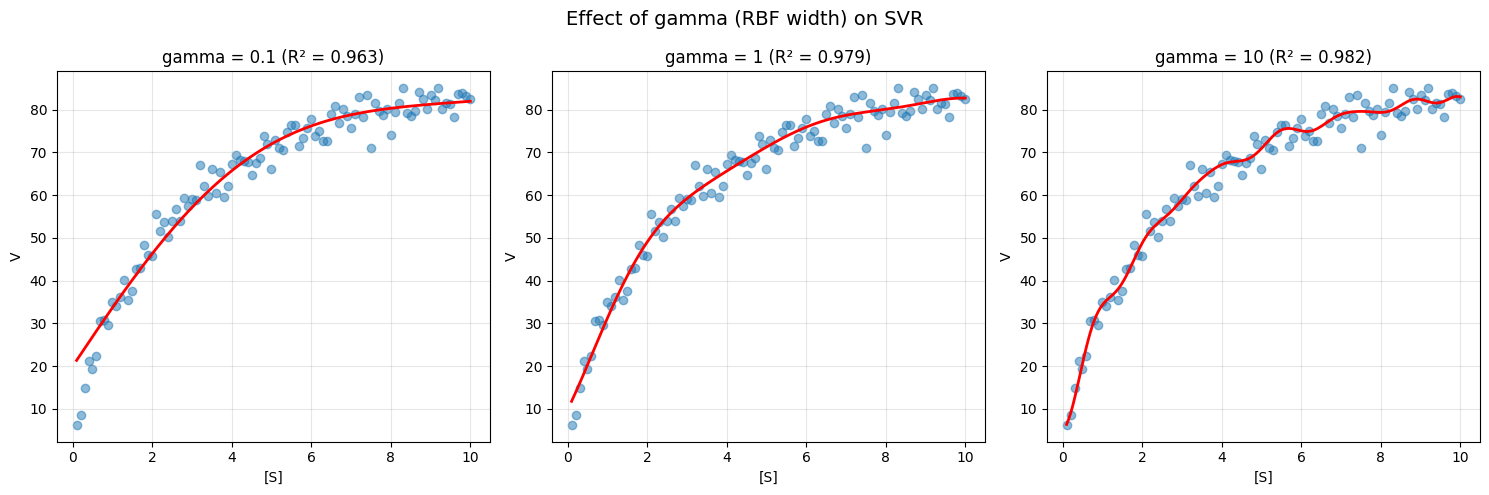

In [10]:
# Effect of gamma
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for ax, gamma in zip(axes, [0.1, 1, 10]):
    svr = SVR(kernel='rbf', C=100, gamma=gamma)
    svr.fit(X_scaled, y)
    
    ax.scatter(S, V, alpha=0.5)
    ax.plot(S_smooth, svr.predict(X_smooth_scaled), 'r-', linewidth=2)
    ax.set_xlabel('[S]')
    ax.set_ylabel('V')
    ax.set_title(f'gamma = {gamma} (R² = {svr.score(X_scaled, y):.3f})')
    ax.grid(True, alpha=0.3)

plt.suptitle('Effect of gamma (RBF width) on SVR', fontsize=14)
plt.tight_layout()
plt.show()

## Tuning SVR with Grid Search

In [11]:
# Grid search for SVR hyperparameters
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svr', SVR(kernel='rbf'))
])

param_grid = {
    'svr__C': [0.1, 1, 10, 100, 1000],
    'svr__gamma': [0.01, 0.1, 1, 10],
    'svr__epsilon': [0.01, 0.1, 0.5]
}

grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='r2', n_jobs=-1)
grid_search.fit(X, y)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best CV R²: {grid_search.best_score_:.4f}")

Best parameters: {'svr__C': 1000, 'svr__epsilon': 0.01, 'svr__gamma': 0.1}
Best CV R²: 0.0979


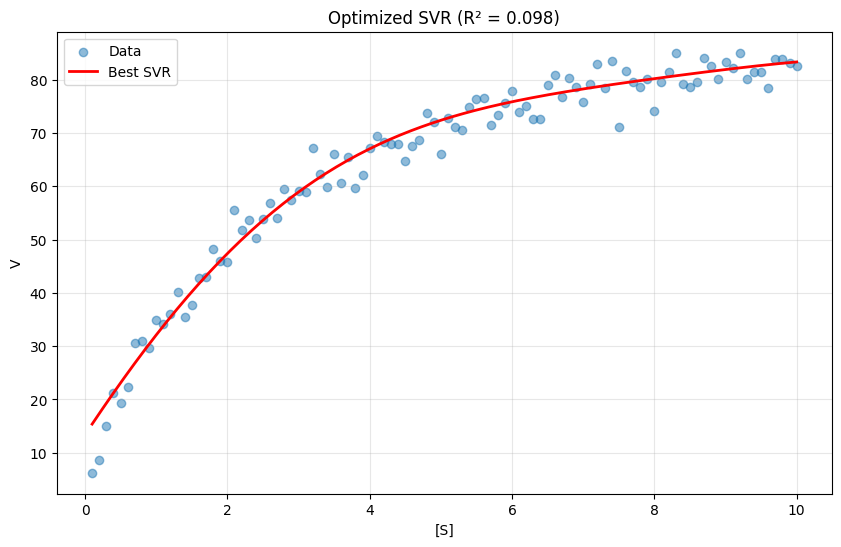

In [12]:
# Plot best model
best_model = grid_search.best_estimator_

plt.figure(figsize=(10, 6))
plt.scatter(S, V, alpha=0.5, label='Data')
plt.plot(S_smooth, best_model.predict(S_smooth), 'r-', linewidth=2, label='Best SVR')
plt.xlabel('[S]')
plt.ylabel('V')
plt.title(f'Optimized SVR (R² = {grid_search.best_score_:.3f})')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## Multi-dimensional Example

Nonlinear methods work with multiple features too.

In [13]:
# Load 2D reaction yield dataset  
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

url = "https://raw.githubusercontent.com/jkitchin/s26-06642/main/dsmles/data/reaction_yield.csv"
df_yield = pd.read_csv(url)

temperature = df_yield['temperature'].values
pressure = df_yield['pressure'].values
yield_rate = df_yield['yield'].values

# Create feature matrix
X_2d = np.column_stack([temperature, pressure])
y_2d = yield_rate

# Train-test split
X_train_2d, X_test_2d, y_train_2d, y_test_2d = train_test_split(
    X_2d, y_2d, test_size=0.2, random_state=42
)

print(f"Dataset shape: {X_2d.shape}")
print(f"Training: {X_train_2d.shape[0]}, Test: {X_test_2d.shape[0]}")

Dataset shape: (200, 2)
Training: 160, Test: 40


In [14]:
# Compare models
models = {
    'Linear': Pipeline([
        ('scaler', StandardScaler()),
        ('model', LinearRegression())
    ]),
    'Polynomial (deg=3)': Pipeline([
        ('poly', PolynomialFeatures(degree=3)),
        ('scaler', StandardScaler()),
        ('model', Ridge(alpha=0.1))
    ]),
    'SVR (RBF)': Pipeline([
        ('scaler', StandardScaler()),
        ('model', SVR(kernel='rbf', C=100))
    ])
}

results = []
for name, model in models.items():
    model.fit(X_train_2d, y_train_2d)
    train_score = model.score(X_train_2d, y_train_2d)
    test_score = model.score(X_test_2d, y_test_2d)
    
    results.append({
        'Model': name,
        'Train R²': train_score,
        'Test R²': test_score
    })

pd.DataFrame(results)

,Model,Train R²,Test R²
0,Linear,0.801374,0.657003
1,Polynomial (deg=3),0.834872,0.653442
2,SVR (RBF),-0.008671,-0.041820


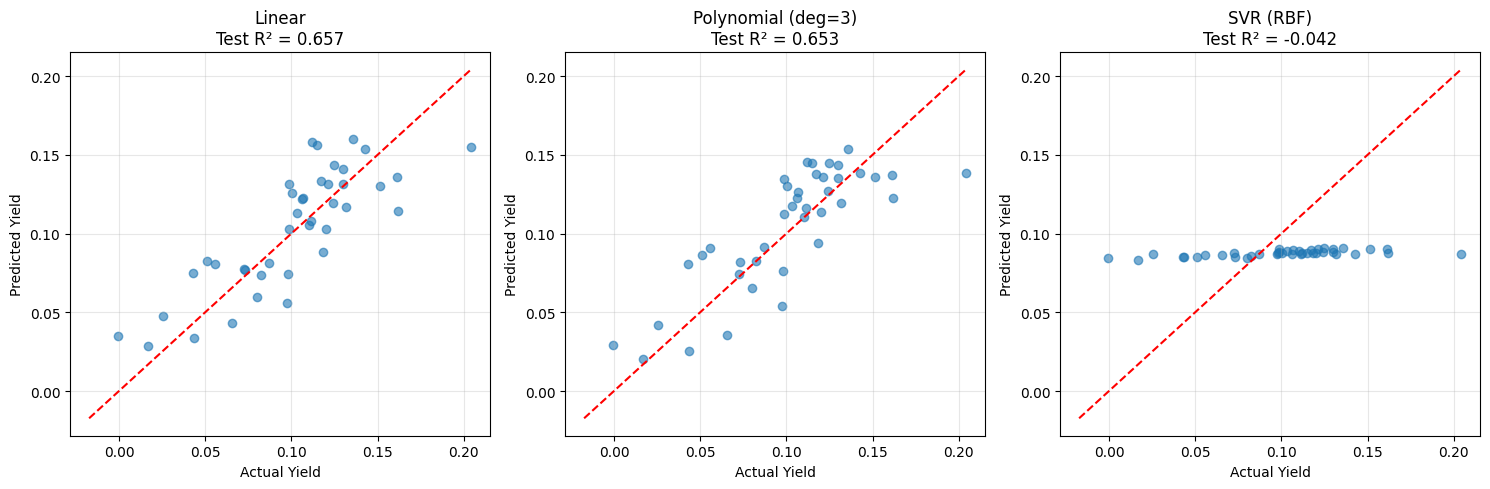

In [15]:
# Visualize predictions
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for ax, (name, model) in zip(axes, models.items()):
    y_pred = model.predict(X_test_2d)
    
    ax.scatter(y_test_2d, y_pred, alpha=0.6)
    ax.plot([y_2d.min(), y_2d.max()], [y_2d.min(), y_2d.max()], 'r--')
    ax.set_xlabel('Actual Yield')
    ax.set_ylabel('Predicted Yield')
    ax.set_title(f'{name}\nTest R² = {r2_score(y_test_2d, y_pred):.3f}')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Model Selection Guidelines

| Situation | Recommended Approach |
|-----------|---------------------|
| Few features, known polynomial form | Polynomial features |
| Many features, unknown relationship | SVR with RBF kernel |
| Need interpretability | Polynomial (lower degree) |
| Large dataset | Consider alternatives (trees, neural nets) |
| Small dataset | SVR often works well |

In [16]:
! pip install -q jupyterquiz
from jupyterquiz import display_quiz

display_quiz("https://raw.githubusercontent.com/jkitchin/s26-06642/main/dsmles/09-nonlinear-methods/quizzes/nonlinear-methods-quiz.json")

/bin/bash: pip: command not found


<IPython.core.display.Javascript object>

## Recommended Reading

These resources explore nonlinear modeling and kernel methods:

1. **[Scikit-learn Support Vector Machines](https://scikit-learn.org/stable/modules/svm.html)** - Official documentation on SVR and SVC. Includes guidance on kernel selection and hyperparameter tuning.

2. **[A Tutorial on Support Vector Regression (Smola & Schölkopf)](https://alex.smola.org/papers/2004/SmoSch04.pdf)** - Clear introduction to SVR theory including the epsilon-insensitive loss function and kernel trick.

3. **[An Introduction to Statistical Learning, Chapter 9](https://www.statlearning.com/)** - Covers support vector machines with intuitive explanations of the maximum margin classifier and kernel methods.

4. **[Kernel Methods in Machine Learning (Hofmann et al., Annals of Statistics 2008)](https://projecteuclid.org/journals/annals-of-statistics/volume-36/issue-3/Kernel-methods-in-machine-learning/10.1214/009053607000000677.full)** - Survey paper on kernel methods providing theoretical foundations for understanding why kernels work.

5. **[Polynomial Regression (Penn State STAT 501)](https://online.stat.psu.edu/stat501/lesson/9)** - Detailed coverage of polynomial regression including when to use it and how to avoid overfitting with high-degree polynomials.

## Summary: Choosing Nonlinear Methods

### Decision Guide

```
Do you know the functional form?
├── Yes → Use that form (log-transform, power law, etc.)
└── No
    ├── Few features (1-3)?
    │   └── Polynomial features (degree 2-4 with regularization)
    └── Many features?
        ├── Small-medium dataset (<10,000)?
        │   └── SVR with RBF kernel
        └── Large dataset?
            └── Consider tree-based methods (next module)
```

### Method Comparison

| Method | Best For | Interpretable? | Key Hyperparameter |
|--------|----------|----------------|-------------------|
| Polynomial | Known polynomial form, few features | Yes | Degree |
| SVR (RBF) | Unknown nonlinearity, small/medium data | No | C, γ, ε |
| SVR (Poly) | Polynomial-like with many features | No | C, degree |

### Key Takeaways

1. **Start simple**: Try degree-2 polynomials before complex methods
2. **Always scale for SVR**: Kernels are sensitive to feature scales
3. **Use cross-validation**: Both polynomial degree and SVR hyperparameters need tuning
4. **Watch for overfitting**: High-degree polynomials and high-C SVR overfit easily
5. **RBF is a good default**: When you don't know the form, RBF usually works

### Common Pitfalls

- Forgetting to scale features before SVR
- Using high-degree polynomials without regularization
- Not tuning hyperparameters (default C=1 is rarely optimal)
- Ignoring the explosion of polynomial features with multiple inputs

## Next Steps

In the next module, we'll learn about ensemble methods (Random Forests, Gradient Boosting) that combine multiple models for even better predictions.

---

## The Catalyst Crisis: Chapter 9 - "When Lines Aren't Enough"

*A story about recognizing the limits of linear models*

---

"We've hit a wall."

Alex said it flatly in the team meeting. They'd squeezed everything they could from linear models. The plateau was real: 0.80 R-squared, 85% of failures caught. Better than nothing. Not good enough.

"The relationship isn't linear," Maya said. "We've known that since the t-SNE clustering. The reactor has multiple operating regimes."

"So we need nonlinear models." Sam pulled up a notebook. "Neural networks? SVMs?"

Professor Pipeline, sitting in the corner, spoke up. "Before you reach for the complicated tools—why isn't it linear?"

Alex thought about it. "Interactions. The effect of temperature depends on catalyst age. The effect of pressure depends on temperature. Everything affects everything."

"And linear models can capture interactions?"

"Only the ones we explicitly code. We'd have to know ahead of time which interactions matter."

"So the problem isn't that you need a nonlinear function. It's that you need to discover which interactions matter." He stood up. "Tomorrow's lecture covers decision trees and ensemble methods. They're nonlinear, yes—but more importantly, they find interactions automatically."

After he left, Maya turned to Alex. "Do you understand what he meant?"

Alex wasn't entirely sure. But she'd learned to trust that clarity would come—not all at once, but incrementally, the way understanding usually did.

"I think he's saying we've been trying to specify the model form ourselves. Trees let the data decide."

That night, Alex reviewed her notebook—the physical one, full of sketches and dead ends. A pattern emerged from the chaos. Every breakthrough had come not from cleverer algorithms, but from asking better questions. What was missing? Why did outliers exist? Which features mattered?

The algorithm didn't solve problems. It answered questions. The art was in knowing which questions to ask.

She added to the mystery board: **Linear models have limits. Next step: let the data find interactions we didn't anticipate.**

---

*Continue to the next lecture to discover the power of ensemble methods...*